In [64]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.widgets import Slider
import numpy as np
import tigre
import tigre.algorithms as algs
import SimpleITK as sitk


In [2]:
folder = rf'D:\TC_UESC\TC1_Caracol'

In [3]:
'''
Função para leitura de uma imagem (tipo raw) individual
fileName -  nome do arquivo
dimX, dimY - dimensão em pixels da imagem
_type - tipo de dado no arquivo, no XRMC float64
_offset - bloco de cabecalho do arquivo de imagem em bytes, no XRMC (60 bytes)
'''
def readRawImgFromDetector(fileName, dimX, dimY, _type, _offset=0):
    img = np.fromfile(fileName, dtype=_type, count=dimX*dimY, offset=_offset)
    img = img.reshape((dimX, dimY))
    return img

In [4]:
'''
Função para leitura de um diretorio (ou subconjunto) de imagens de um diretorio contendo imagens de simulação
folderName - nome (path) do diretorio
fileNamePrefix - prefixo do nome do arquivo de imagem  
initImg - indice (grau) da imagem inicial, geralmente 0
finalImg - indice (grau) da imagem final, geralmente 359
step -  paso em grau entre as imagens, geralmente 1 
dimX, dimY - dimensão em pixels da imagem
_type - tipo de dado no arquivo, no XRMC float64
_offset - bloco de cabecalho do arquivo de imagem em bytes, no XRMC (60 bytes)
'''
def readRawImgFolder(folderName, fileNamePrefix, initImg, finalImg, step, dimX, dimY, _type, _offset=0):
    fileName = rf'{folderName}\{fileNamePrefix}{initImg:d}.dat'
    imgs = readRawImgFromDetector(fileName, dimX, dimY, _type, _offset)
    for i in range(initImg+step, finalImg, step):
        fileName = rf'{folderName}\{fileNamePrefix}{i:d}.dat'
        img = readRawImgFromDetector(fileName, dimX, dimY, _type, _offset)
        imgs = np.dstack((imgs, img))
    return imgs.transpose((2, 0, 1))

In [5]:
'''
Função para imprimir os detalhes de uma imagem após a leitura 
img - matriz da imagem
desc -  comentario opcional sobre a imagem
'''
def printImgData(img, desc = None):
    if desc!=None:
        print(f'{desc}:: ', end='')
    print(f'Shape:{img.shape}, Min:{img.min():.4e}, Max:{img.max():.4e}, Mean:{img.mean():.4e}, Type:{img.dtype}')

In [6]:
flats = readRawImgFolder(rf'{folder}\flat', 'flat', 1, 6, 1, 1200, 1400, np.uint16)
printImgData(flats)

Shape:(5, 1200, 1400), Min:1.0000e+00, Max:1.6383e+04, Mean:1.5338e+04, Type:uint16


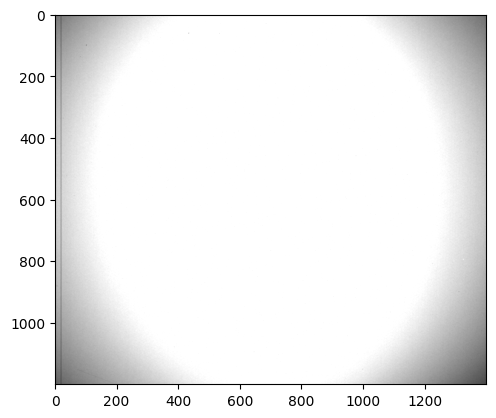

In [7]:
plt.imshow(flats[2,:,:], cmap='gray')

Flat Field Image:: Shape:(1200, 1400), Min:1.0000e+00, Max:1.6383e+04, Mean:1.5337e+04, Type:float32


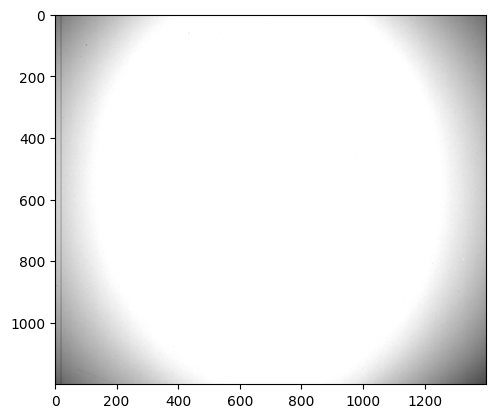

In [8]:
flat = np.mean(flats, axis=0).astype(np.float32)

printImgData(flat, 'Flat Field Image')
plt.imshow(flat, cmap='gray')

Falta fazer a analise de estabilidade dos flats:
- Diferenca com relação a média
- RMS da diferencia
- Maximo RMS

Shape:(5, 1200, 1400), Min:1.0000e+00, Max:1.6383e+04, Mean:8.3088e+02, Type:uint16


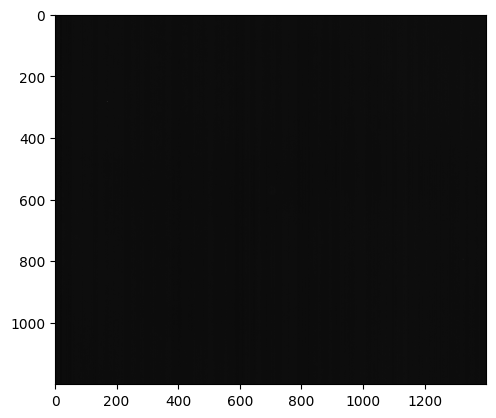

In [9]:
darks = readRawImgFolder(rf'{folder}\dark', 'dark', 1, 6, 1, 1200, 1400, np.uint16)
printImgData(darks)
plt.imshow(darks[2,:,:], cmap='gray')

Dark Field Image:: Shape:(1200, 1400), Min:1.0000e+00, Max:1.6383e+04, Mean:8.3088e+02, Type:float32


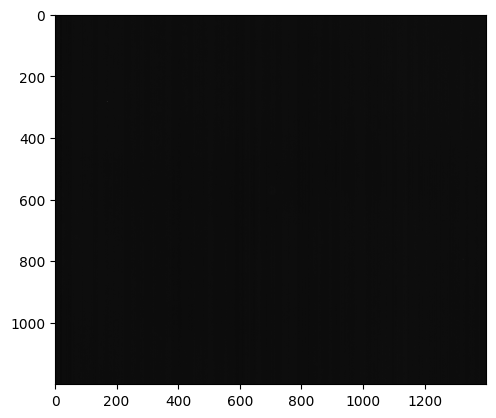

In [10]:
dark = np.mean(darks, axis=0).astype(np.float32)

printImgData(dark, 'Dark Field Image')
plt.imshow(dark, cmap='gray')

Falta analise de estabilidade do dark

In [11]:
prjs = readRawImgFolder(rf'{folder}\200prjs', 'img', 1, 201, 1, 1200, 1400, np.uint16)
printImgData(prjs)

Shape:(200, 1200, 1400), Min:1.0000e+00, Max:1.6383e+04, Mean:1.1914e+04, Type:uint16


In [12]:
#Funcao fixa, falta generalizar, colocar 3 imagens por linha
def funMosaicPrjs(_prjs):
    nroP = 200
    stepP = 20
    posMos = []
    for i in range(nroP//(2*stepP)):
        posMos.append([2*i, 2*i+1])

    #print(posMos)

    fig, ax = plt.subplot_mosaic(posMos, figsize=(7, 16))

    for i in range(0, nroP//stepP): 
        ax[i].imshow(_prjs[i*stepP-1,:,:,], cmap="gray")#, vmin=0, vmax=0.6)
        ax[i].set_title(f'Prj {i*stepP-1}', fontsize = 10)

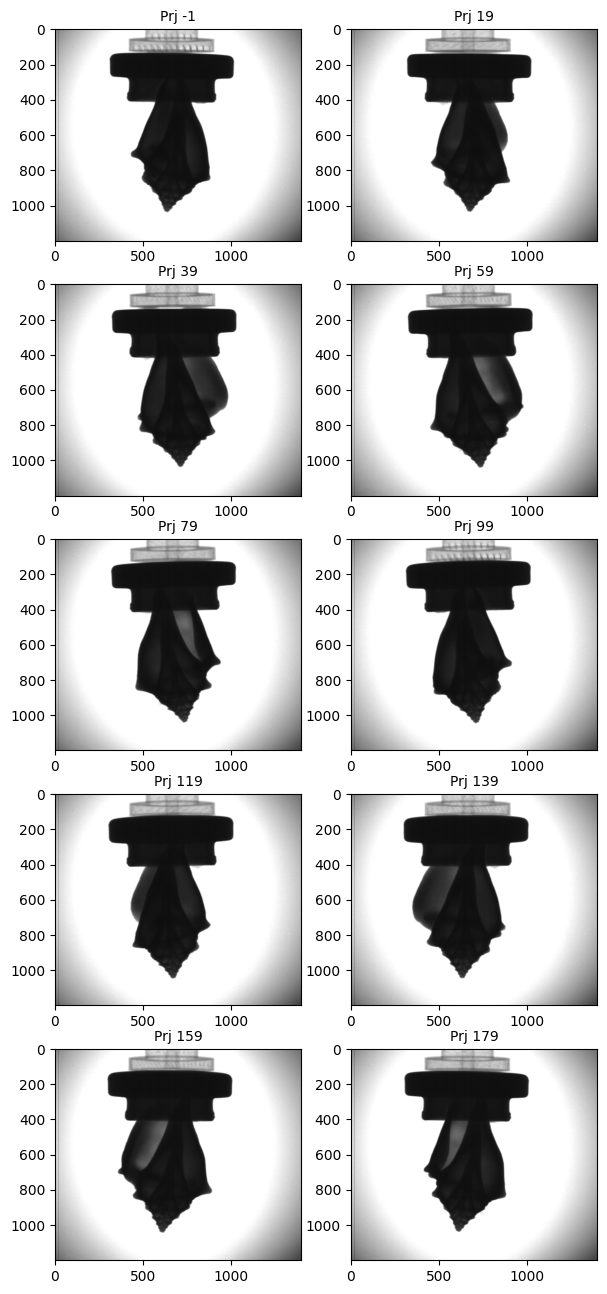

In [13]:
funMosaicPrjs(prjs)

In [14]:
'''
Função para gerar um mosaico com 2 planos (linhas do detector) selecionadas do sinograma
Dados de entrada:
    _sino - sino com as projeções [angulos, linhas, colunas]
    _lines - linhas do detector a serem exibidas, default [100, 130], considerando um detector de 200 linhas
    _minv - valor minimo da escala de cinzas
    _maxv - valor maximo da escala de cinzas
'''
def plotTwoSinoPlanes(_sino, _lines = [100, 130], _minv=0, _maxv=1):
    fig, ax = plt.subplot_mosaic([[0, 1]], figsize=(10, 6))


    ax[0].imshow(_sino[:, _lines[0], :], cmap="gray", vmin=_minv, vmax=_maxv)
    ax[0].set_title(f'Linha {_lines[0]}', fontsize = 12)

    ax[1].imshow(_sino[:, _lines[1], :], cmap="gray", vmin=_minv, vmax=_maxv)
    ax[1].set_title(f'Linha {_lines[1]}', fontsize = 12)

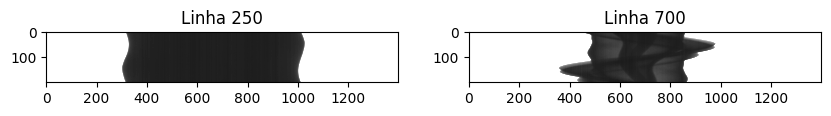

In [15]:
plotTwoSinoPlanes(prjs, [250, 700], 0, 8200)

Corrected Projections:: Shape:(200, 1200, 1400), Min:-3.0081e-03, Max:1.4453e+00, Mean:7.7904e-01, Type:float32
Valores negativos: 240323, de um total de 336000000, porcentagem: 0.0715
Valores negativos: 0, de um total de 336000000, porcentagem: 0.0000
Corrected Projections:: Shape:(200, 1200, 1000), Min:2.6070e-05, Max:1.1515e+00, Mean:6.9128e-01, Type:float32


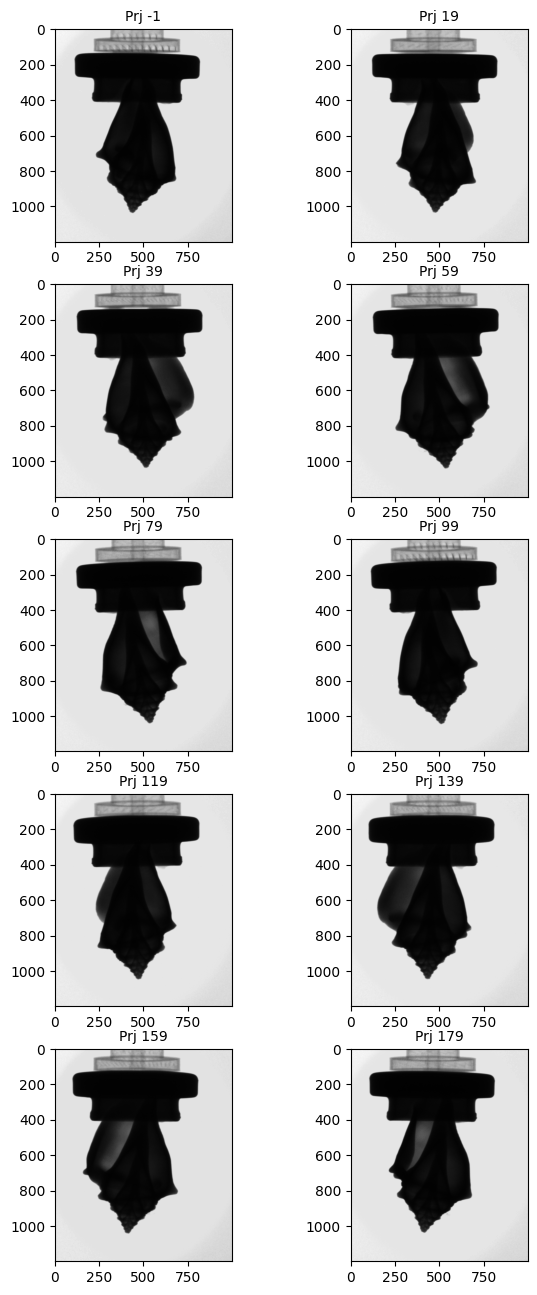

In [22]:
projs_correct = (prjs - dark) / (flat - dark + 1e-3)
printImgData(projs_correct, 'Corrected Projections')

neg_values = np.sum(projs_correct<=0)

print(f'Valores negativos: {neg_values}, de um total de {projs_correct.size}, porcentagem: {100*neg_values/projs_correct.size:.4f}')

projs_correct[projs_correct<=0] = 1e-2

neg_values = np.sum(projs_correct<=0)

print(f'Valores negativos: {neg_values}, de um total de {projs_correct.size}, porcentagem: {100*neg_values/projs_correct.size:.4f}')

projs_correct = projs_correct[:, :, 200:1200]
printImgData(projs_correct, 'Corrected Projections')

funMosaicPrjs(projs_correct)


In [20]:
## @brief Displaces the array by a continuous offset.
#  @param X The input array to displace.
#  @param b The displacement value.
#  @return The displaced array.
def displaceCont(X, b):
    XDisplaced = np.zeros(X.shape)
    for i in range(len(X)):
        t = i+b
        t1 = np.floor(t)
        t2 = np.ceil(t)
        w = t-t1
        
        x1 = X[int(t1)] if (int(t1)<len(X)) and (int(t1)>=0) else 0.0
        x2 = X[int(t2)] if (int(t2)<len(X)) and (int(t2)>=0) else 0.0
        
        x = (1.0-w)*x1 + w*x2
        XDisplaced[i] = x
        
    return XDisplaced

## @brief Computes the error between two profiles, with a displacement applied to one of them.
#  @param _dValue Displacement value.
#  @param PF1 First profile array.
#  @param PF2 Second profile array.
#  @return The mean squared error between the profiles.
def findError(_dValue, PF1, PF2):
    F2_ = displaceCont(PF2,_dValue)
    delta = int(abs(_dValue))
    #print(delta, PF1.shape[0])
    CF1 = PF1[delta:PF1.shape[0]-delta]
    CF2 = F2_[delta:F2_.shape[0]-delta]
    e = np.mean( (CF1 - CF2)**2 )
    return e

## @brief Finds the position of minimum error between two profiles.
#  @param PF1 First profile array.
#  @param PF2 Second profile array.
#  @param _scan Range of displacements to scan.
#  @return The displacement value that minimizes the error.
def findMinPos(PF1, PF2, _scan):
    e1=1e12
    minValDisp = 0
    # print("e1: ", e1)
    for t in np.linspace(-_scan, _scan, 2*_scan+1):
        e = findError(t, PF1, PF2)
        # print("t: ", t,  "| error: ", e)
        if (e<e1):            
            e1=e
            minValDisp = t
    return minValDisp

## @brief Divides a sinogram line into two halves.
#  @param _sinoP The input sinogram profile.
#  @return Two halves of the sinogram, with the second half reversed.
def divideSinoLine(_sinoP):
    _F = np.sum(np.sum(_sinoP,axis=2),axis=1)
    M = _F.shape[0]
    _F1 = _F[:M//2]
    _F2 = _F[M//2:]
    _F2 = _F2[::-1]
    return _F1, _F2

## @brief Extracts the width displacement from a sinogram.
#  @param sinoP The input sinogram profile.
#  @param scan The range of displacements to scan.
#  @return The width displacement value.
def extractWidthDisplacement(sinoP, scan=20):
    
    F1, F2 = divideSinoLine(sinoP)
    print('Divide Sino', F1.shape, F2.shape)
    PosMin = findMinPos(F1, F2, scan)
    return PosMin

## @brief Detect and fix misalignment in a sinogram - CEPEDI standart procedure
#  @param sino The input sinogram.
#  @param SCAN Initial scan range for detecting misalignment.
#  @return The corrected sinogram.
def detect_and_fix_misalignment(sino, SCAN):
    
    Result = SCAN

    while ((abs(Result) == SCAN) and (SCAN < 500)):
        Result = extractWidthDisplacement(sino, SCAN)
        # print( 'Interval: ', SCAN, 'Width: ', Result)
        if (abs(Result) == SCAN):
            SCAN = 2*SCAN
            Result = SCAN

    print("Misalignment found: ", Result)
    if Result == 0:
        print("No misalignment detected, returning original sinogram")
        return sino
    else:
        print("Correcting misalignment...")
        posMiss = int(abs(Result)//2)
        if (Result > 0):
            tmpstr = 'left side.'
        else:
            tmpstr = 'right side.'
            posMiss = -posMiss
        sino = np.roll(sino, posMiss, axis=0)
        print("Misalignment correction finished")        
        return sino

In [23]:
projs_correct_align = detect_and_fix_misalignment(projs_correct.transpose(2,1,0), 100).transpose(2,1,0)
printImgData(projs_correct_align, 'Corrected Projections - Aligned')

Divide Sino (500,) (500,)
Misalignment found:  66.0
Correcting misalignment...
Misalignment correction finished
Corrected Projections - Aligned:: Shape:(200, 1200, 1000), Min:2.6070e-05, Max:1.1515e+00, Mean:6.9128e-01, Type:float32


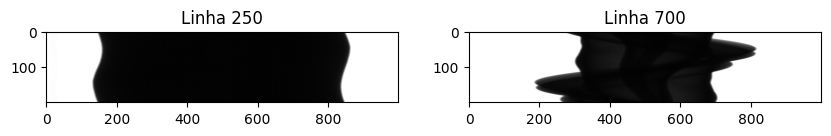

In [25]:
plotTwoSinoPlanes(projs_correct_align, [250, 700], 0, 1)

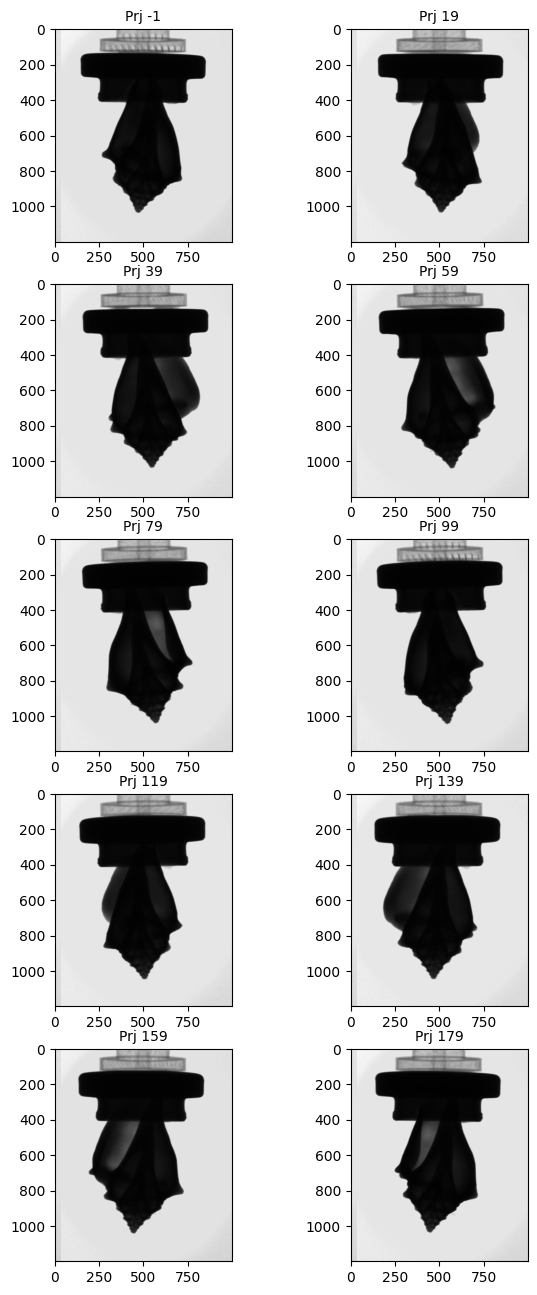

In [81]:
funMosaicPrjs(projs_correct_align)

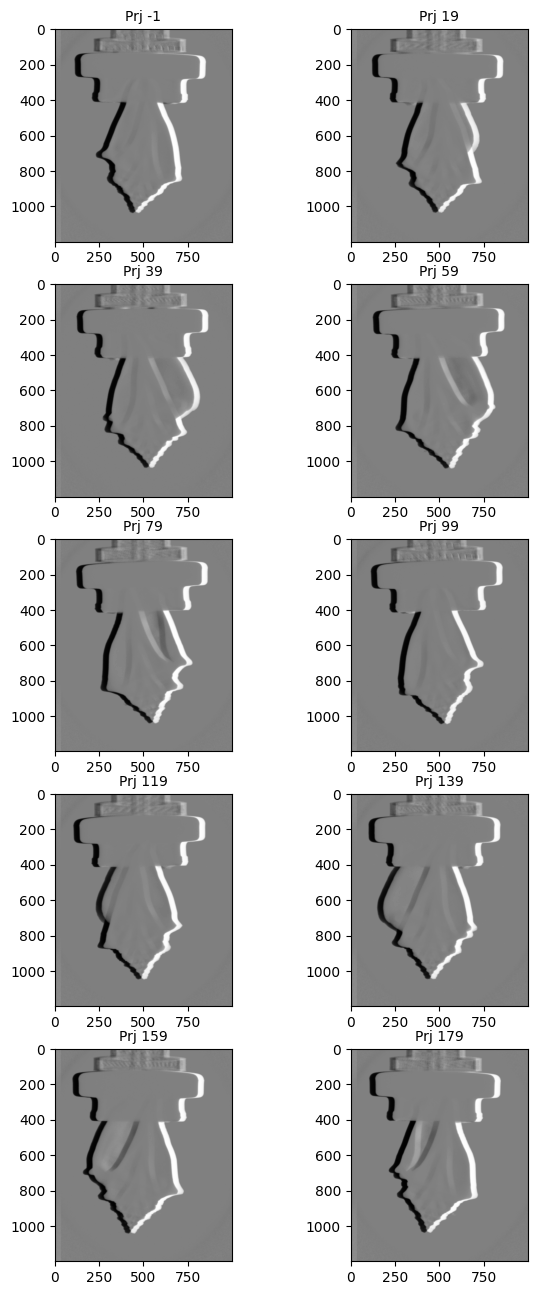

In [27]:
funMosaicPrjs(projs_correct-projs_correct_align)

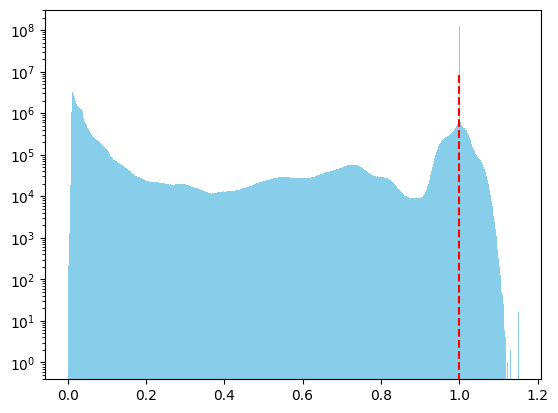

In [28]:
#Construir o histograma
fig = plt.figure()
ax = plt.axes()
ax.hist(projs_correct_align[:,:,:].flatten(), bins=1024, color='skyblue', log=True)
ax.plot([1.00, 1.00], [0, 1e7], 'r--')

(0.9, 1.1)

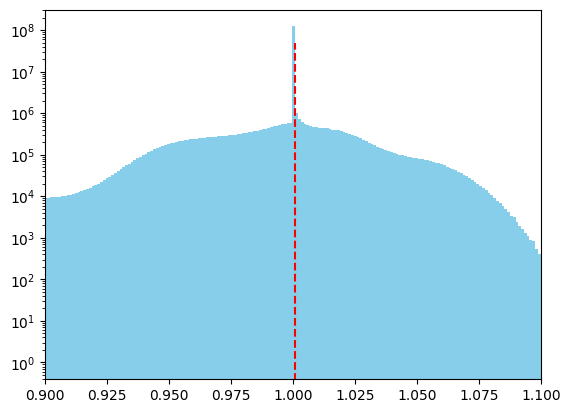

In [29]:
#Pico do fundo do histograma
fig = plt.figure()
ax = plt.axes()
ax.hist(projs_correct[:,:,:].flatten(), bins=1024, color='skyblue', log=True)
ax.plot([1.0006, 1.0006], [0, 5e7], 'r--')
ax.set_xlim(0.9, 1.1)

In [71]:
#projs_correct[projs_correct>1.0006] = 1.0006

projs_ln = -np.log(projs_correct_align/1.0006)

In [31]:
#%% Definir a geometria 
geo = tigre.geometry_default(high_resolution=True)

In [46]:
# Distances
geo.DSD = 546  # Distance Source Detector      (mm)
geo.DSO = 440  # Distance Source Origin        (mm)
# Detector parameters
geo.nDetector = np.array([1200, 1000])  # number of pixels              (px)
geo.dDetector = np.array([0.1, 0.1])  # size of each pixel            (mm)
geo.sDetector = geo.nDetector * geo.dDetector  # total size of the detector    (mm)
# Image parameters
geo.nVoxel = np.array([600, 500, 500])  # number of voxels              (vx)
geo.sVoxel = np.array([96.7033, 80.5861, 80.5861])  # total size of the image       (mm)
geo.dVoxel = geo.sVoxel / geo.nVoxel  # size of each voxel            (mm)

geo.accuracy = 0.25

In [47]:
print(geo)

TIGRE parameters
-----
Geometry parameters
Distance from source to detector (DSD) = 546 mm
Distance from source to origin (DSO)= 440 mm
-----
Detector parameters
Number of pixels (nDetector) = [1200 1000]
Size of each pixel (dDetector) = [0.1 0.1] mm
Total size of the detector (sDetector) = [120. 100.] mm
-----
Image parameters
Number of voxels (nVoxel) = [600 500 500]
Total size of the image (sVoxel) = [96.7033 80.5861 80.5861] mm
Size of each voxel (dVoxel) = [0.16117217 0.1611722  0.1611722 ] mm
-----
Offset correction parameters
Offset of image from origin (offOrigin) = [0 0 0] mm
Offset of detector (offDetector) = [0 0] mm
-----
Auxillary parameters
Samples per pixel of forward projection (accuracy) = 0.25


In [34]:
#angles = np.linspace(0, 356.4, 100)
angles = np.linspace(0, 358.2, 200)
angles = angles * np.pi / 180

In [35]:
print(angles.shape)
print(angles[0:10]*180/np.pi)
print(angles[190:200]*180/np.pi)

(200,)
[ 0.   1.8  3.6  5.4  7.2  9.  10.8 12.6 14.4 16.2]
[342.  343.8 345.6 347.4 349.2 351.  352.8 354.6 356.4 358.2]


In [72]:
imgFDK = algs.fdk(projs_ln, geo, angles)

FDK Start
Filtering time: 9.151510 seconds
Backprojection time: 1.898061 seconds
Execution time: 11.049571 seconds
FDK End.


In [75]:
imgOSSART = algs.ossart(projs_ln, geo, angles, niter=20)

OSSART algorithm in progress.
Estimated time until completion : 00:06:11


In [76]:
print('FDK:', imgFDK.shape, imgFDK.min(), imgFDK.max(), imgFDK.mean())
print('OSSART:', imgOSSART.shape, imgOSSART.min(), imgOSSART.max(), imgOSSART.mean())

FDK: (600, 500, 500) -0.38764167 0.7165653 0.013897606
OSSART: (600, 500, 500) 0.0 0.6270268 0.0135476645


Text(0.5, 1.0, 'OSSART - Slice 400')

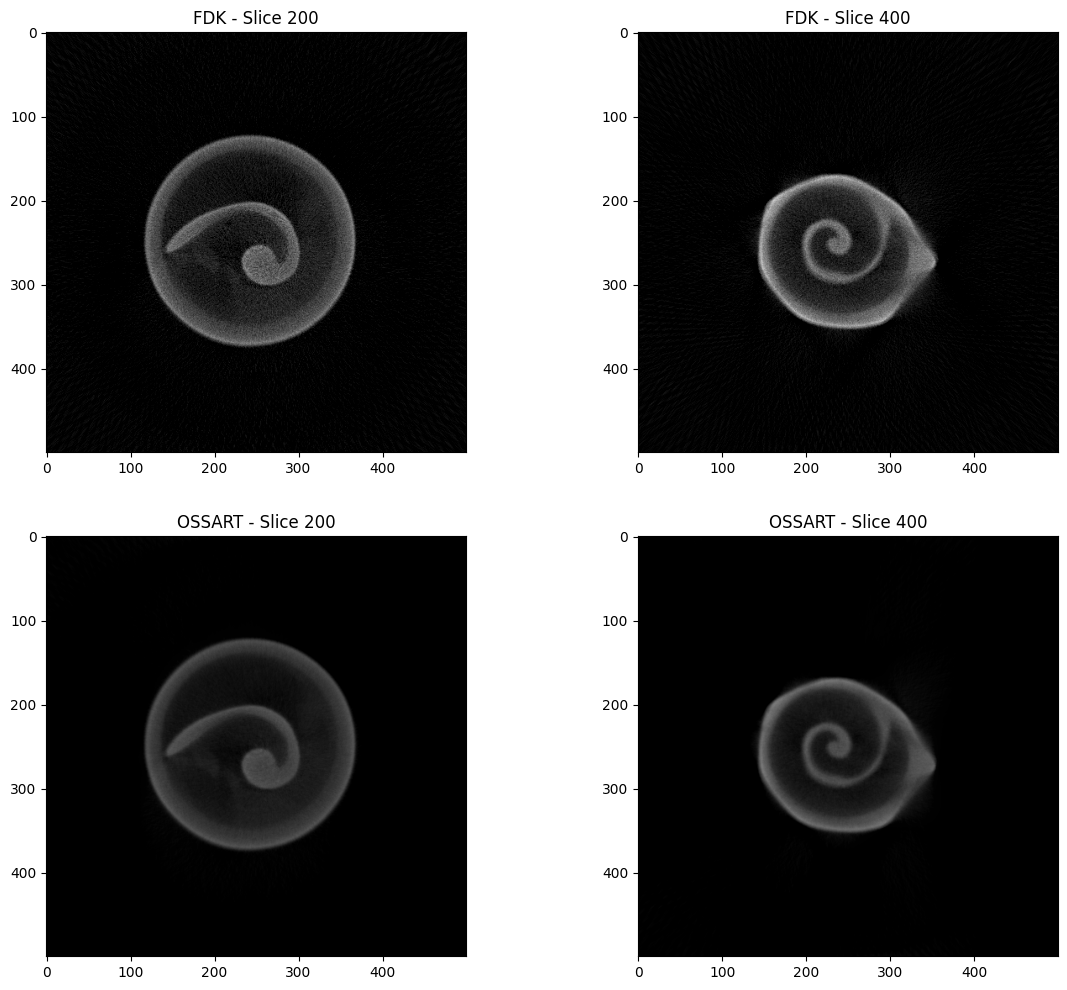

In [77]:
fig, ax = plt.subplot_mosaic([[0, 1],[2, 3]], figsize=(14, 12))

_slice = 200

ax[0].imshow(imgFDK[_slice, :, :], cmap="gray", vmin=0, vmax=0.5)
ax[0].set_title(f'FDK - Slice {_slice}', fontsize = 12)
#ax[0].invert_yaxis()
ax[1].imshow(imgFDK[2*_slice, :, :], cmap="gray", vmin=0, vmax=0.5)
ax[1].set_title(f'FDK - Slice {2*_slice}', fontsize = 12)
#ax[1].invert_yaxis()

ax[2].imshow(imgOSSART[_slice, :, :], cmap="gray", vmin=0.0, vmax=0.7)
ax[2].set_title(f'OSSART - Slice {_slice}', fontsize = 12)
#ax[0].invert_yaxis()
ax[3].imshow(imgOSSART[2*_slice, :, :], cmap="gray", vmin=0.0, vmax=0.7)
ax[3].set_title(f'OSSART - Slice {2*_slice}', fontsize = 12)
#ax[1].invert_yaxis()

In [82]:
np.savez(rf'{folder}\imgFDK.npz', volume=imgFDK)
np.savez(rf'{folder}\imgOSSART.npz', volume=imgOSSART)
np.savez(rf'{folder}\sino_correted_align.npz', sino=projs_correct_align)

In [66]:
def salvar_como_mhd_raw(array_np, nome_base="imagem", espaco_voxel=(1.0, 1.0, 1.0)):

    # Converte para imagem SimpleITK
    imagem_sitk = sitk.GetImageFromArray(array_np.astype(np.uint16))  # ou np.uint16, conforme o tipo

    # Define o espaçamento dos voxels (em ordem Z, Y, X)
    imagem_sitk.SetSpacing(espaco_voxel)

    # Salva no formato .mhd/.raw
    sitk.WriteImage(imagem_sitk, f"{nome_base}.mhd")

def gerarViews(volume, mini=0, maxi=1000):
    # Selecionar a fatia central para análise
    num_slices, height, width = volume.shape
    print(volume.shape)

    fig, ax = plt.subplots(figsize=(15,157))
    plt.imshow(volume[num_slices//2,:,:], cmap='gray',vmin=mini, vmax=maxi)
    plt.show()

    fig, ax = plt.subplots(figsize=(15, 7))
    plt.imshow(volume[:,height//2,:], cmap='gray',vmin=mini, vmax=maxi)
    plt.show()

    fig, ax = plt.subplots(figsize=(15, 7))
    plt.imshow(volume[:,:,width//2], cmap='gray',vmin=mini, vmax=maxi)
    plt.show()

(600, 500, 500)


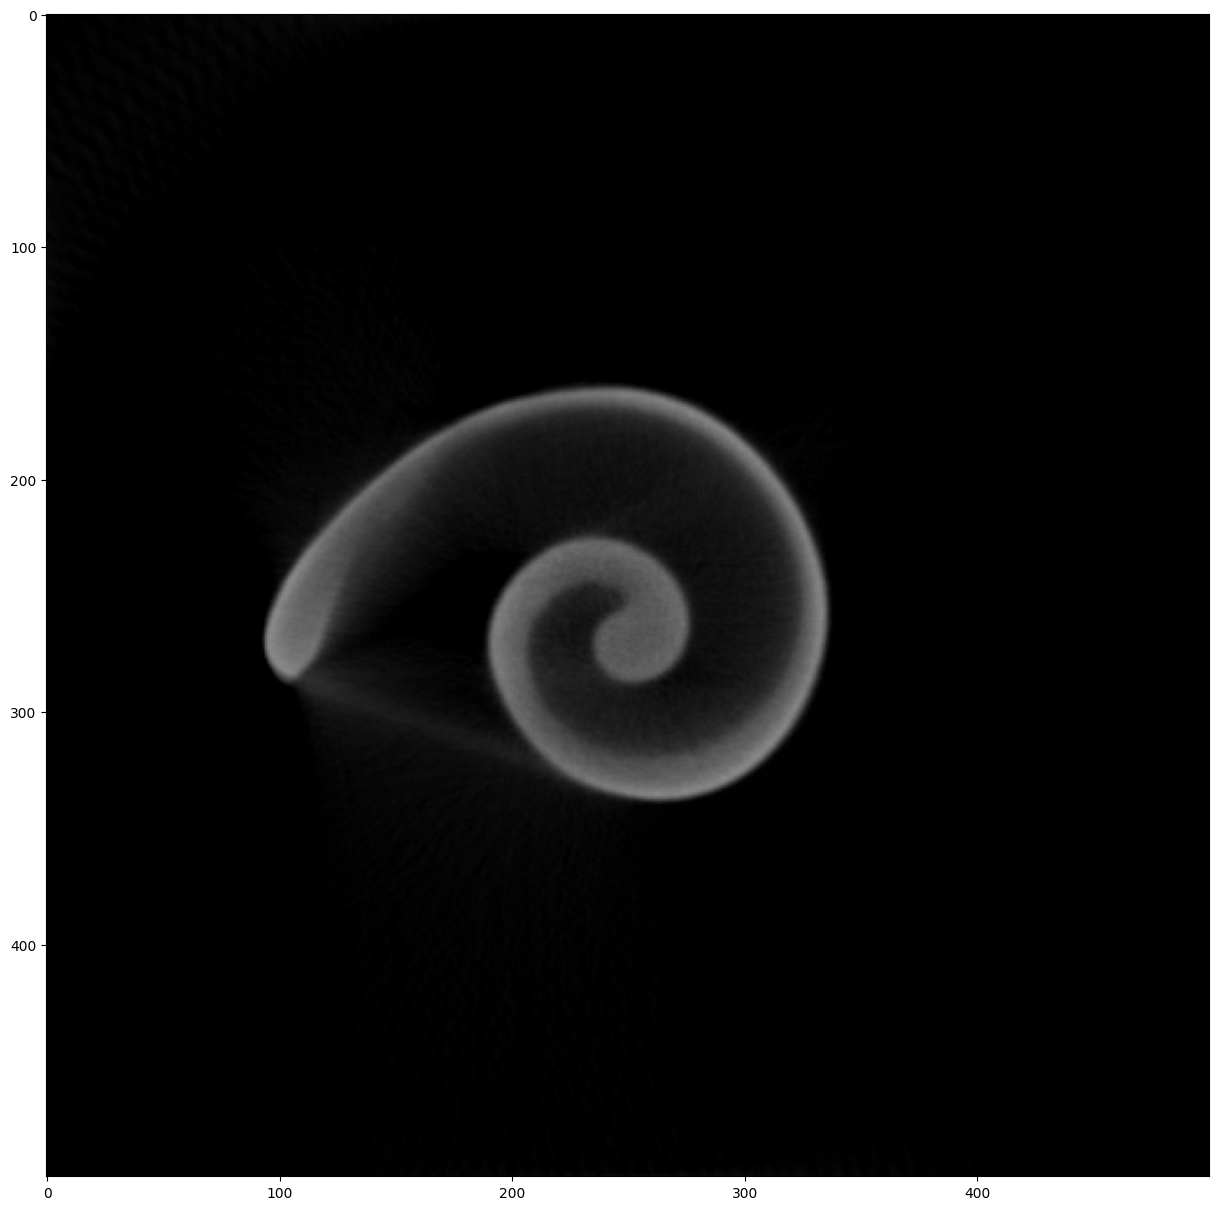

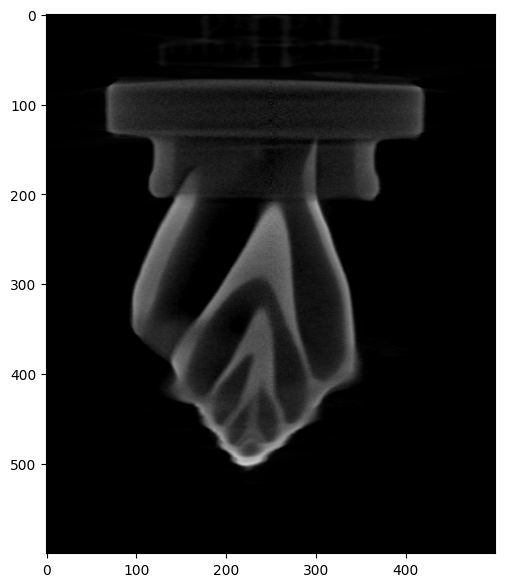

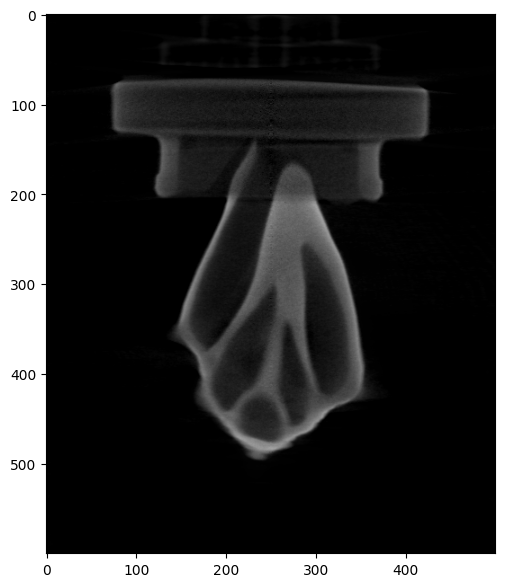

In [80]:
volume = imgOSSART  # A chave pode variar; verifique com list(data.keys())
_max = volume.max()
gerarViews(volume, 0, _max)
salvar_como_mhd_raw(volume*65535/_max, nome_base=rf"{folder}\CARACOL_UINT16", espaco_voxel=(1.0, 1.0, 1.0))